# Anomaly detection in time series

This was taken from [Pramit Choudhary's DataScience.com blog post](https://www.datascience.com/blog/python-anomaly-detection) on anomaly detection in time series. The series used was the number of sunspots vs time. There is a natural fluctuation to the cycle.

I have made some small changes, namely:
1. Added the &sigma;-value error bars
2. Replaced the deprecated Pandas functions `pd.rolling_std( <df> ) 

In [98]:
from itertools import izip, count

import numpy as np
import pandas as pd
import collections

from numpy import linspace, loadtxt, ones, convolve

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

%matplotlib inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [99]:
sunspot_data = pd.read_csv("sunspots.txt",delimiter = '\t', header= None, names = ['month','sunspots'])

In [100]:
sunspot_data.head()

,month,sunspots
0,0,58.0
1,1,62.6
2,2,70.0
3,3,55.7
4,4,85.0


In [101]:
def explain_anomalies(y, window_size, sigma = 1.0):
    rolling = y.rolling(window_size)
    average = rolling.mean().replace(np.nan, y)
    residual = y - average
    std = np.std(residual)
    return {'standard_deviation': std,
            'anomalies_dict': collections.OrderedDict(
            [(index,y_i) for index, y_i, avg_i in izip(count(), y, average)
            if abs(y_i - avg_i) > sigma * std]
        )}

def explain_anomalies_rolling_std(y, window_size, sigma = 1.0):
    rolling = y.rolling(window_size)
    average = rolling.mean().replace(np.nan, y)
    residual = y - average
    
    testing_std = residual.rolling(window_size).std()
    return {'standard_deviation': testing_std,
            'anomalies_dict': collections.OrderedDict(
            [(index, y_i) for index, y_i, avg_i, rs_i in izip(count(), y, average, testing_std)
            if abs(y_i - avg_i) > sigma*rs_i])}

In [102]:
def plot_results(x, y, window_size, num_sigma = 1.0, text_xlabel = "X Axis", 
                text_ylabel = "Y Axis", apply_rolling_std=False):
    plt.figure(figsize = (15,8))
    plt.plot(x,y,'k.')
    y_av = y.rolling(window_size).mean()
    plt.plot(x,y_av, color='green')
    plt.xlim(x.min(),x.max())
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    if apply_rolling_std:
        anomaly_function = explain_anomalies_rolling_std
    else:
        anomaly_function = explain_anomalies
        
    events = anomaly_function(y, window_size = window_size, sigma=num_sigma)
    
    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype = int, count = len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(),dtype=float,count = len(events['anomalies_dict']))
    y_lower = y_av - num_sigma * events['standard_deviation']
    y_upper = y_av + num_sigma * events['standard_deviation']
    
    plt.plot(x_anomaly, y_anomaly,'r*', markersize = 12)
    plt.fill_between(x, y_upper, y_lower,alpha = 0.3)
    plt.grid(True)
    

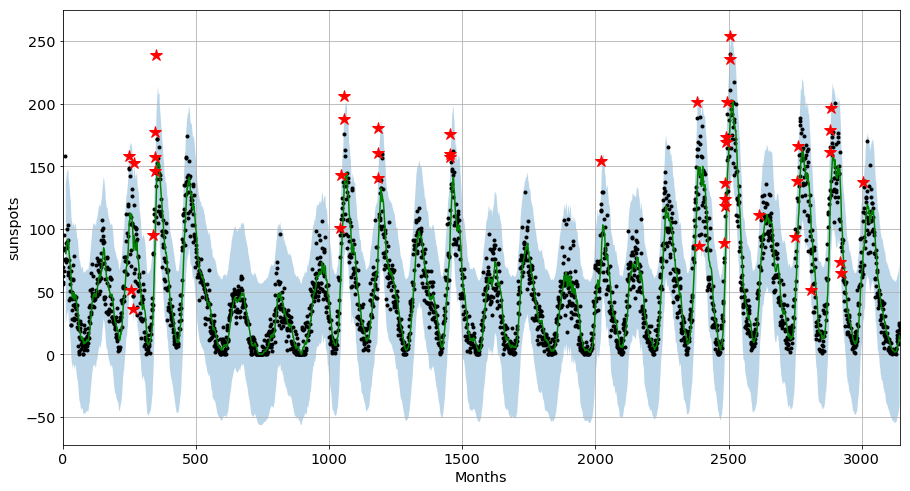

In [103]:
plot_results(sunspot_data['month'], sunspot_data['sunspots'], window_size = 13, text_xlabel = "Months", 
             text_ylabel="sunspots", num_sigma = 3, apply_rolling_std = False)